In [356]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d


import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

import os
import itertools

from utils import *

In [335]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
AVG_EARTH_RADIUS_KM = 6371.0088
PAZ_WA = {'sensitivity': 2800,
          'zeros': [0j],
          'gain': 1,
          'poles': [-6.2832 - 4.7124j, -6.2832 + 4.7124j]}

NETWORKS = "IS"
STATIONS = ','.join(['MLDT', 'CVYN', 'MNHM', 'SHGL', 'ALMT', 'GLHS', 'ENGV', 'TVR', 'MGDL', 'SPR', 'KNHM', 
                    'RMOT', 'HDNS', 'AMID', 'ZEFT', 'RSPN', 'KSHO', 'KDZV', 'HULT', 'ZRT'])
CHANNELS = str([''.join(ch) for ch in itertools.product("BHSE", "LHN", "?")])[1:-1].replace("'", '')

LAT = 32.80
LON = 35.60
MAX_RAD = 0.4
MIN_MAG = 2.0
DOWNLOAD_INV_CAT = False
DOWNLOAD_EVENTS = False
LOAD_LOCATION = True
PICK = False
CATALOG_PATH = "catalog.xml"
INV_PATH = "inventory.xml"
WAVEFORMS_PATH = 'waveforms'
PICK_DIR_PATH = 'picking/location'
LOCATION_DIR_PATH = 'location'
SPEEDS = (3.5, 4.0, 4.5)

In [4]:
isr_fdsn = "http://82.102.143.46:8181"
client = Client(isr_fdsn)#, user='niv.keren@gmail.com', password='fdsnisfun1', timeout=240)

In [5]:
my_events = pd.read_csv("events.csv").sort_values(["event time"])
all_events = pd.read_csv("all_events.csv").set_index('event_time')
waveforms_raw = []
waveforms_detrented = []
waveforms_filtered = []

In [6]:
for idx, event in my_events.iterrows():
    cat_event = all_events.loc[event['event time']]
    my_events.loc[idx, "cat_lat"] = cat_event.lat
    my_events.loc[idx, "cat_lon"] = cat_event.lon
    my_events.loc[idx, "cat_mag"] = cat_event.magnitude
my_events = my_events.reset_index(drop=True)
my_events

event time  cat_lat  cat_lon          cat_mag
0   2018-07-04T01:50:06.667000Z   32.848   35.583   4.797476941 M 
1   2018-07-04T01:54:26.532000Z   32.859   35.585   2.552366975 M 
2   2018-07-04T03:57:39.993000Z   32.840   35.597   3.288243713 M 
3   2018-07-04T19:45:39.428000Z   32.843   35.572   4.761445325 M 
4   2018-07-04T19:51:24.449000Z   32.852   35.578   3.821342778 M 
5   2018-07-05T04:00:03.956000Z   32.848   35.579   2.975286543 M 
6   2018-07-05T16:51:36.987000Z   32.836   35.574   2.957468776 M 
7   2018-07-06T05:38:54.227000Z   32.861   35.569   2.760879312 M 
8   2018-07-07T02:07:44.383000Z   32.837   35.599   3.993414954 M 
9   2018-07-08T12:52:17.385000Z   32.846   35.578   3.099346613 M 
10  2018-07-08T18:36:51.126000Z   32.854   35.572   2.912091227 M 
11  2018-07-09T05:26:40.210000Z   32.869   35.574   2.544967346 M 
12  2018-07-10T19:25:20.385000Z   32.836   35.587   2.661807031 M 
13  2018-07-12T07:00:35.280000Z   32.871   35.575   3.304634746 M 
14  2018-07-13T06:06:45.300000Z   32.879   35.593   2.620838931 M 
15  2018-07-18T15:24:09.149000Z   32.865   35.574   2.860077441 M 
16  2018-07-27T11:56:37.960000Z   32.873   35.564   2.751016607 M 
17  2018-07-29T00:07:54.796000Z   32.862   35.575   3.482041205 M 
18  2018-07-31T01:30:49.702000Z   32.824   35.583    3.26786428 M 
19  2018-08-08T23:21:09.796000Z   32.830   35.590   2.529741661 M

### **Download/Load Inventory & Catalog**

In [38]:
if DOWNLOAD_INV_CAT:
    inv, catalog = download_inv_cat(client, my_events["event time"], NETWORKS, STATIONS, CHANNELS, LAT, LON, MAX_RAD, MIN_MAG)
else:
    inv = obspy.read_inventory(INV_PATH, format="STATIONXML")
    print(f"loaded inventory from:{INV_PATH}")
    catalog = obspy.read_events(CATALOG_PATH, format="QUAKEML")
    print(f"loaded catalog from:{CATALOG_PATH}")


columns = ["network", "station", "latitude", "longitude", "elevation"]
stations_df = pd.DataFrame(columns=columns)
for network in inv:
    for i, station in enumerate(network):
        stations_df.loc[i, ["network", "station", "latitude", "longitude", "elevation"]] = \
            network.code, station.code, station.latitude.real, station.longitude.real, station.elevation
stations_df = stations_df.astype({"latitude" : "float64",
                                  "longitude" : "float64",
                                  "elevation" : "float64"})

loaded inventory from:inventory.xml
loaded catalog from:catalog.xml


### **Download/Load waveform files**

In [8]:
if DOWNLOAD_EVENTS:
    waveforms_raw, waveforms_detrented, waveforms_filtered = download_waveforms(client, my_events, NETWORKS, STATIONS, CHANNELS)
else:
    waveforms_raw, waveforms_detrented, waveforms_filtered = load_waveforms(WAVEFORMS_PATH)

loading mseed file: waveforms/2018-07-04T01:50:01.667000Z-2018-07-04T01:50:36.667000Z.mseed
loading mseed file: waveforms/2018-07-04T01:54:21.532000Z-2018-07-04T01:54:56.532000Z.mseed
loading mseed file: waveforms/2018-07-04T03:57:34.993000Z-2018-07-04T03:58:09.993000Z.mseed
loading mseed file: waveforms/2018-07-04T19:45:34.428000Z-2018-07-04T19:46:09.428000Z.mseed
loading mseed file: waveforms/2018-07-04T19:51:19.449000Z-2018-07-04T19:51:54.449000Z.mseed
loading mseed file: waveforms/2018-07-05T03:59:58.956000Z-2018-07-05T04:00:33.956000Z.mseed
loading mseed file: waveforms/2018-07-05T16:51:31.987000Z-2018-07-05T16:52:06.987000Z.mseed
loading mseed file: waveforms/2018-07-06T05:38:49.227000Z-2018-07-06T05:39:24.227000Z.mseed
loading mseed file: waveforms/2018-07-07T02:07:39.383000Z-2018-07-07T02:08:14.383000Z.mseed
loading mseed file: waveforms/2018-07-08T12:52:12.385000Z-2018-07-08T12:52:47.385000Z.mseed
loading mseed file: waveforms/2018-07-08T18:36:46.126000Z-2018-07-08T18:37:21.12

### **Picking (load or pick)**

In [143]:
index_cols = ["station", "channel"]
events_dfs = []
if PICK:
    for i in range(completed_idx + 1, len(my_events)):
        df_event = event_df(waveforms_raw[i], waveforms_filtered[i], inv, catalog[i])
        df_event.reset_index().to_csv(f'{my_events.loc[i, "event time"]}.csv')
        completed_idx = i
        events_dfs.append(df_event)
else:
    events_csvs = [os.path.join(PICK_DIR_PATH,path) for path in os.listdir(PICK_DIR_PATH) 
                   if os.path.isfile(os.path.join(PICK_DIR_PATH,path)) and path.lower().endswith('.csv')]
    events_csvs.sort()
    events_dfs = [pd.read_csv(path).set_index(index_cols) for path in events_csvs]

## **Location**

---


In [11]:
def location(event_id, event_data, wx, wy, delta_x, delta_y, vps=(4.0, ), depths=(5, 6, 7, 8, 9)):
    pairs = list(itertools.combinations(range(len(event_data)), 2))
    time_differences = [UTCDateTime(event_data.iloc[p[0]]["tp"]) - UTCDateTime(event_data.iloc[p[1]]["tp"]) for p in pairs]
    results = {}
    for p in ("pp", "ps"):
        results[p] = {"mrs_min": np.inf,
                      "depth": depths[0]}
    for vp, depth in itertools.product(vps, depths):
        mrs = {"pp": np.zeros((wy, wx)),
               "ps": np.zeros((wy, wx))}
        for y in range(wy):
            for x in range(wx):

                gx = x * delta_x
                gy = y * delta_y
                tt = [0 for i in range(num_stations)]

                r_sum_pp = 0
                r_sum_ps = 0

                #calculate S-P residua at this cell(x,y,z) by comparing travel time difference with onset time difference
                # t0 = tp-ttp = ts-tts -> tp-ttp - (ts-tts) = 0 -> (tp-ts) - (ttp - tts) = 0
                # tp - ts := t0 + ttp - (t0 + tts) = ttp - tts 

                for s in range(num_stations):      
                    tt[s] = np.sqrt((event_data.iloc[s]["x"] - gx)**2 
                                  + (event_data.iloc[s]["y"] - gy)**2 
                                  + ((event_data.iloc[s]["elevation"] - event_data.iloc[s]["local_depth"]) / 1000 - depth)**2) / vp            
                    ttp = tt[s]
                    tts = ttp * 1.73
                
                    r_sum_ps += np.abs((tts - ttp) - (UTCDateTime(event_data.iloc[s]["ts"]) - UTCDateTime(event_data.iloc[s]["tp"])))        
                for ci in range(len(pairs)): 
                    #CONSTRAINTS (ci): thickness of constraints
                    #if np.abs((tt[i[ci][0]] - tt[i[ci][1]]) - c[ci]) < 0.1: rSum+=1
                    #RESIDUA
                    r_sum_pp += np.abs((tt[pairs[ci][0]] - tt[pairs[ci][1]]) - time_differences[ci])
                mrs["ps"][y][x] = r_sum_ps
                mrs["pp"][y][x] = r_sum_pp
        
        for p in ("pp", "ps"):
            np.save(f"{event_id}-{p}-{depth}-{vp}", mrs[p])
            if mrs[p].min() < results[p]["mrs_min"]:
                results[p]["mrs"] = mrs[p].copy()
                results[p]["mrs_min"] = mrs[p].min()
                results[p]["depth"] = depth
                results[p]["vp"] = vp
                results[p]["location"] = (np.unravel_index(mrs[p].argmin(), mrs[p].shape))
    
    return results


In [285]:
MARGIN_SIZE = 5
res_events = []
for i, event in my_events.iterrows():
    event_id = event["event time"]
    event_data = events_dfs[i].dropna(axis="index", subset=["tp", "ts"])
    min_lat = event_data["lat"].min()
    min_lon = event_data["lon"].min()
    
    (x_stations, y_stations), delta_x, delta_y = conversite(event_data["lat"], event_data["lon"], grid_size=100)
    event_data["x"] = x_stations + MARGIN_SIZE
    event_data["y"] = y_stations + MARGIN_SIZE

    wx = int((event_data["x"].max() + MARGIN_SIZE) / delta_x)
    wy = int((event_data["y"].max() + MARGIN_SIZE) / delta_y)

    cat_location = event[["cat_lat", "cat_lon"]].values.astype(np.float)
    cat_location_x, cat_location_y = absolute2relative((min_lat, min_lon), cat_location)
    my_events.loc[i, "cat_x"] = cat_location_x + MARGIN_SIZE
    my_events.loc[i, "cat_y"] = cat_location_y + MARGIN_SIZE
    my_events.loc[i, "delta_x"] = delta_x
    my_events.loc[i, "delta_y"] = delta_y
    
    if LOAD_LOCATION:
        results = load_location(LOCATION_DIR_PATH, event_id, ("pp", "ps"), SPEEDS)
    else:
        results = location(event_id, event_data,
                           wx, wy, delta_x, delta_y, vps=SPEEDS, depths=np.linspace(1, 10, 10))
    
    for key, value in results.items():
        my_events.loc[i, f"{key}_y"] = value["location"][0] * my_events.loc[i, "delta_y"]
        my_events.loc[i, f"{key}_x"] = value["location"][1] * my_events.loc[i, "delta_x"]
        
        lat, lon = relative2absolute(min_lat, min_lon,
                                     my_events.loc[i, f"{key}_x"] - MARGIN_SIZE, my_events.loc[i, f"{key}_y"] - MARGIN_SIZE)
        
        my_events.loc[i, f"{key}_lat"] = lat
        my_events.loc[i, f"{key}_lon"] = lon
        my_events.loc[i, f"{key}_depth"] = value["depth"]
        my_events.loc[i, f"{key}_vp"] = value["vp"]
        
        for idx, station in event_data.iterrows():
             event_data.loc[station.name, f"{key}_distance"] = \
                np.sqrt((station["x"] - my_events.loc[i, f"{key}_x"])**2
                        + (station["y"] - my_events.loc[i, f"{key}_y"])**2
                        + ((station["elevation"] - station["local_depth"]) / 1000 - value["depth"])**2)
    res_events.append(results)
    event_data.to_csv(f"{event_id}-location.csv")
my_events.to_csv(f"my_events_loaction-{UTCDateTime.now().date}.csv")
    

Text(0, 0.5, 'Depth[km]')

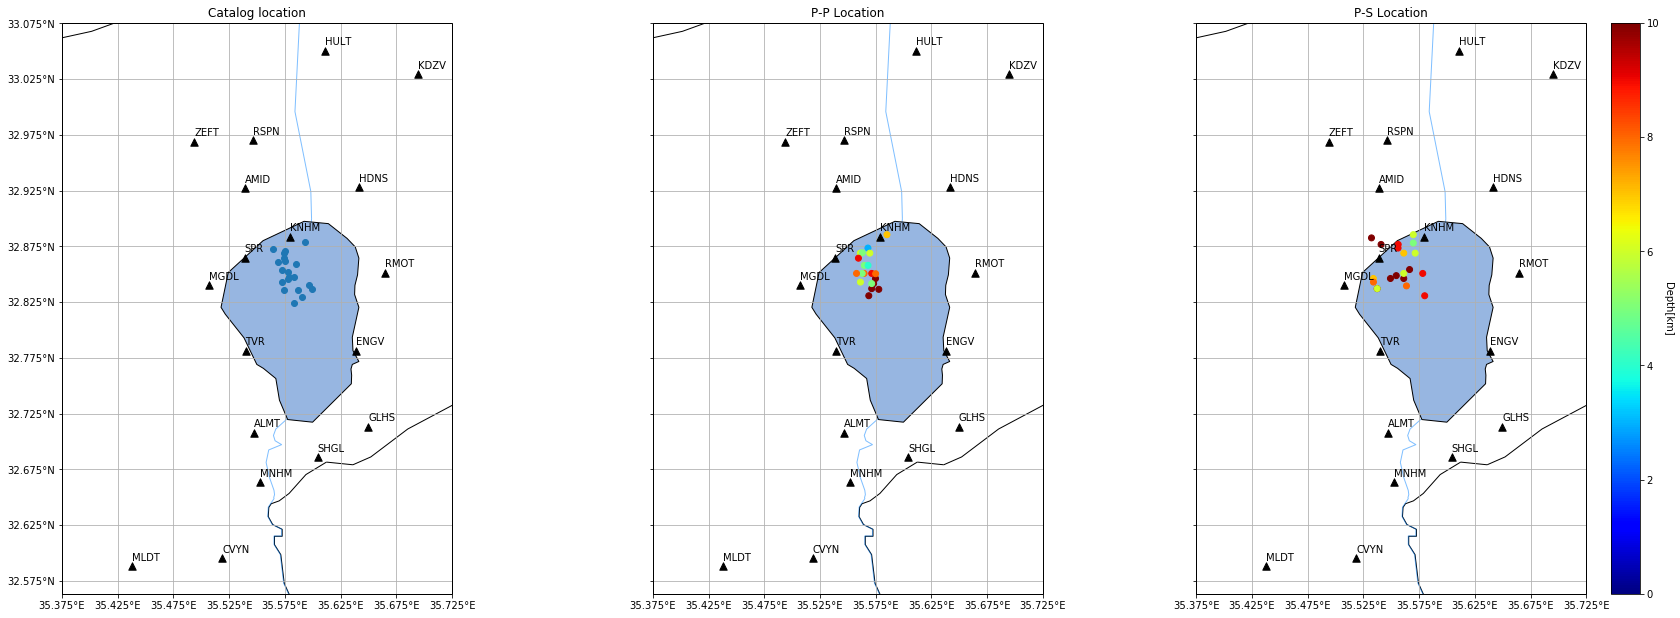

In [346]:
station_size, location_size = 55, 100
label_offset_x, label_offset_y = 0, 0.005

fig = plt.figure(figsize = (30, 10.5))
projection = ccrs.PlateCarree()
ax_cat = fig.add_subplot(1, 3, 1, projection = projection)
ax_pp = fig.add_subplot(1, 3, 2, projection = projection)
ax_ps = fig.add_subplot(1, 3, 3, projection = projection)


stations_df1 = stations_df.reset_index().set_index(["network", "station"]).drop(("IS", "ZRT")).reset_index()
ax_cat = plot_map(ax_cat, stations_df1["latitude"].min(), stations_df1["latitude"].max(),
                  stations_df1["longitude"].min(), stations_df1["longitude"].max(), xticks=True, yticks=True)
ax_pp = plot_map(ax_pp, stations_df1["latitude"].min(), stations_df1["latitude"].max(),
                  stations_df1["longitude"].min(), stations_df1["longitude"].max(), xticks=True, yticks=False)
ax_ps = plot_map(ax_ps, stations_df1["latitude"].min(), stations_df1["latitude"].max(),
                  stations_df1["longitude"].min(), stations_df1["longitude"].max(), xticks=True, yticks=False)
               
for ax in (ax_cat, ax_pp, ax_ps):
    ax.scatter(stations_df1["longitude"], stations_df1["latitude"], marker='^', s=station_size, c='k', zorder=2)
    for station in stations_df1.iterrows():
        ax.text(station[1]["longitude"] + label_offset_x, station[1]["latitude"] + label_offset_y, station[1]["station"])
        
ax_cat.scatter(my_events["cat_lon"], my_events["cat_lat"], zorder=3)
ax_cat.set_title("Catalog location")

sc_pp = ax_pp.scatter(my_events["pp_lon"], my_events["pp_lat"], c=my_events["pp_depth"], vmin=0, vmax=10, cmap=cm.jet, zorder=3)
ax_pp.set_title("P-P Location")
# cbar_pp = ax_pp.figure.colorbar(sc_pp, ax=ax_pp)
# cbar_pp.ax.set_ylabel("Depth[km]", rotation=-90, va="bottom")

sc_ps = ax_ps.scatter(my_events["ps_lon"], my_events["ps_lat"], c=my_events["ps_depth"], vmin=0, vmax=10, cmap=cm.jet, zorder=3)

ax_ps.set_title("P-S Location")

cbar_ps = ax_pp.figure.colorbar(sc_ps, ax=ax_ps)
cbar_ps.ax.set_ylabel("Depth[km]", rotation=-90, va="bottom")
# fig.savefig("figures/location_combined.jpg", dpi=300, quality=95)

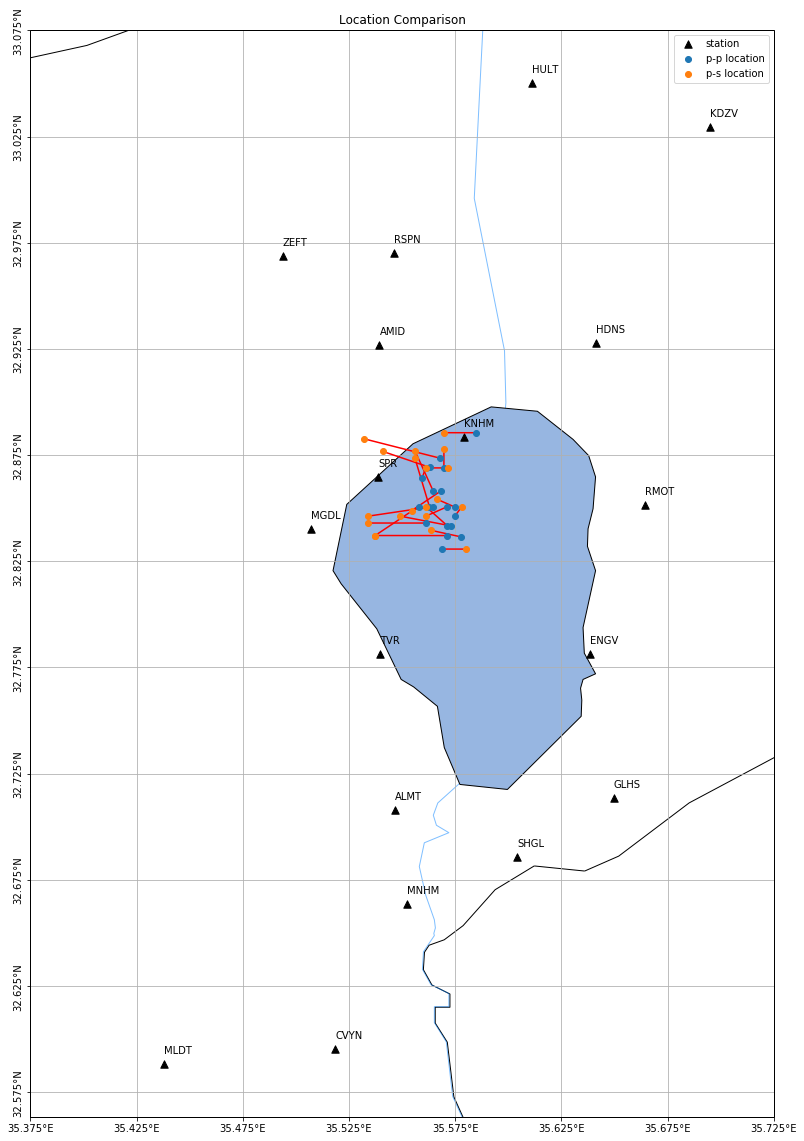

In [343]:
station_size, location_size = 55, 100
label_offset_x, label_offset_y = 0, 0.005

projection = ccrs.PlateCarree()
fig = plt.figure(figsize = (20, 20))
ax = fig.add_subplot(1, 1, 1, projection = projection)

stations_df1 = stations_df.reset_index().set_index(["network", "station"]).drop(("IS", "ZRT")).reset_index()

ax = plot_map(ax, stations_df1["latitude"].min(), stations_df1["latitude"].max(),
              stations_df1["longitude"].min(), stations_df1["longitude"].max(), xticks=True, yticks=True)
    
ax.scatter(stations_df1["longitude"], stations_df1["latitude"], marker='^', s=station_size, c='k', zorder=2, label="station")
for station in stations_df1.iterrows():
    ax.text(station[1]["longitude"] + label_offset_x, station[1]["latitude"] + label_offset_y, station[1]["station"])
        
ax.scatter(my_events["pp_lon"], my_events["pp_lat"], zorder=3, label='p-p location')
ax.scatter(my_events["ps_lon"], my_events["ps_lat"], zorder=3, label='p-s location')
ax.set_title("Location Comparison")

for i, event in my_events.iterrows():
    plt.plot((event["pp_lon"], event["ps_lon"]), (event["pp_lat"], event["ps_lat"]), 'r-')
ax.legend()
fig.savefig("figures/location_comparision.jpg", dpi=300, quality=95)

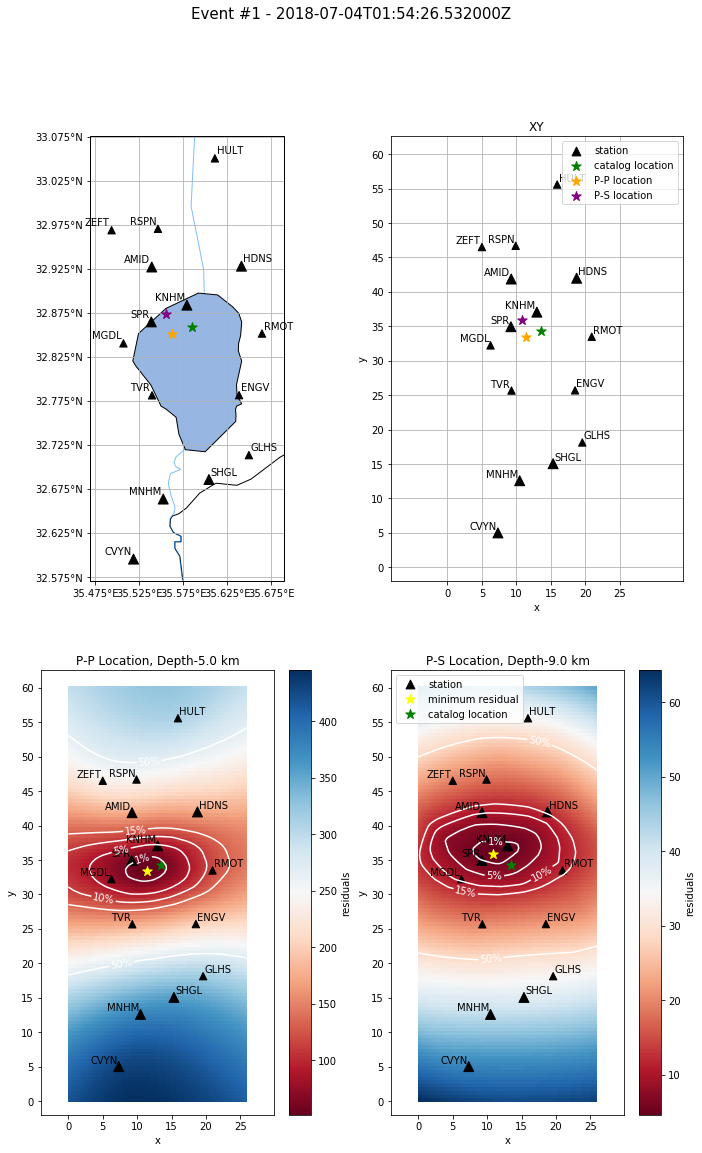

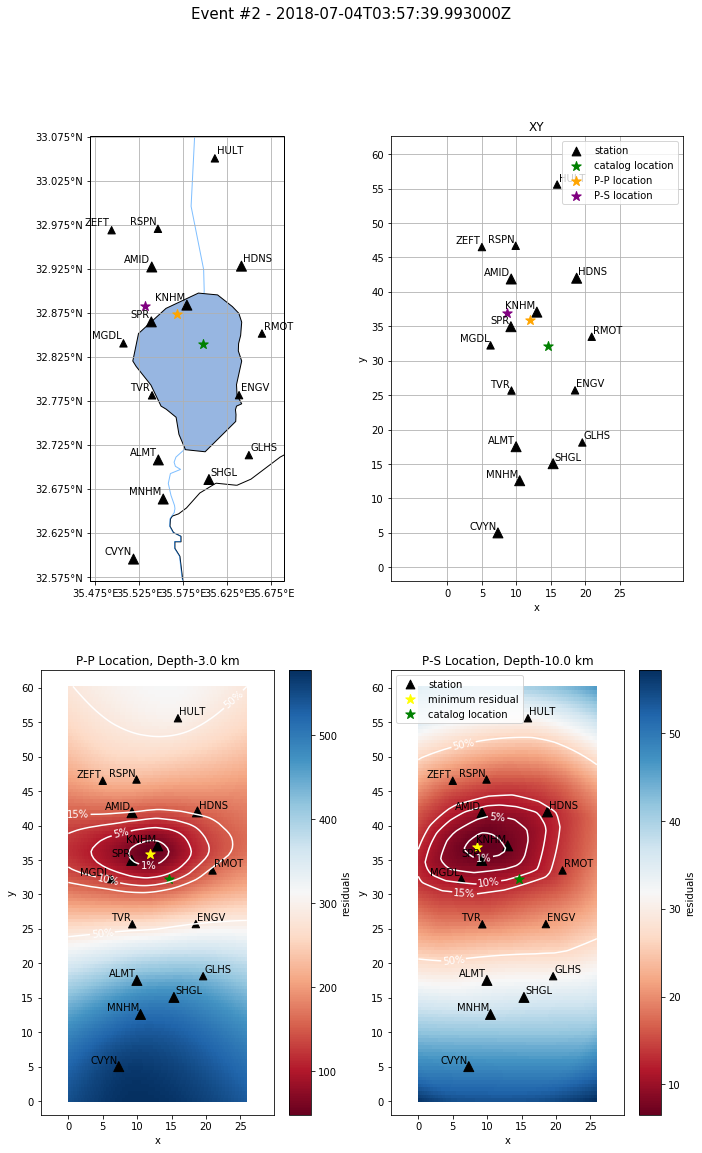

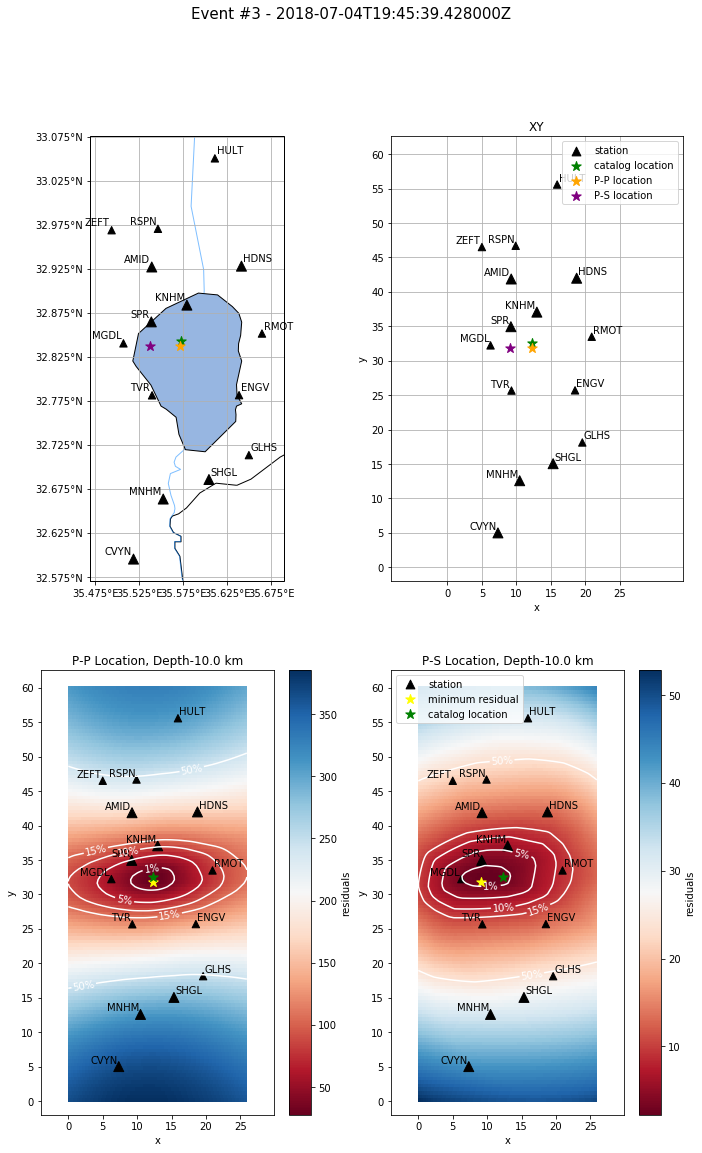

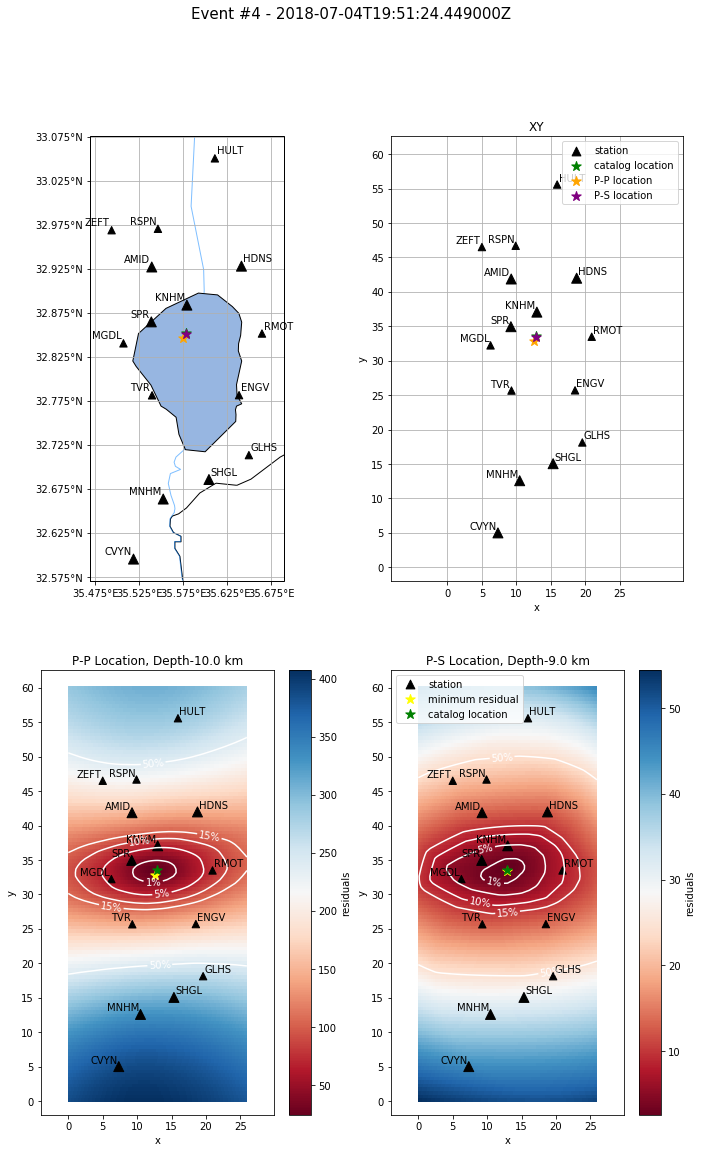

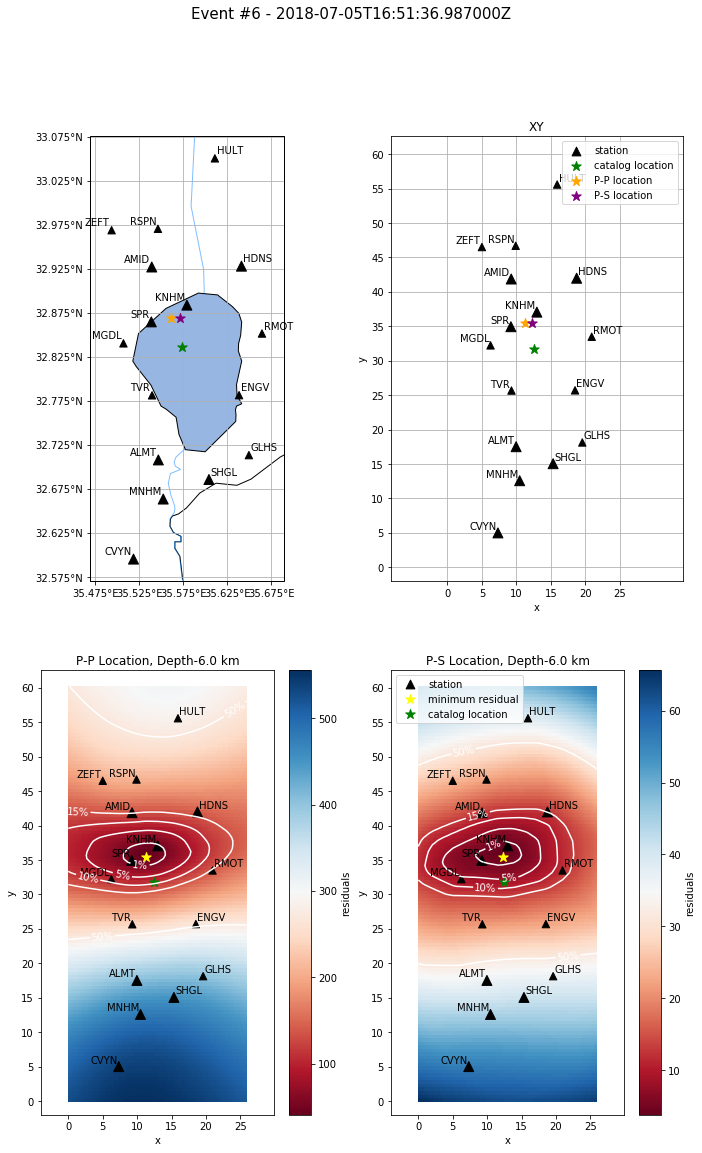

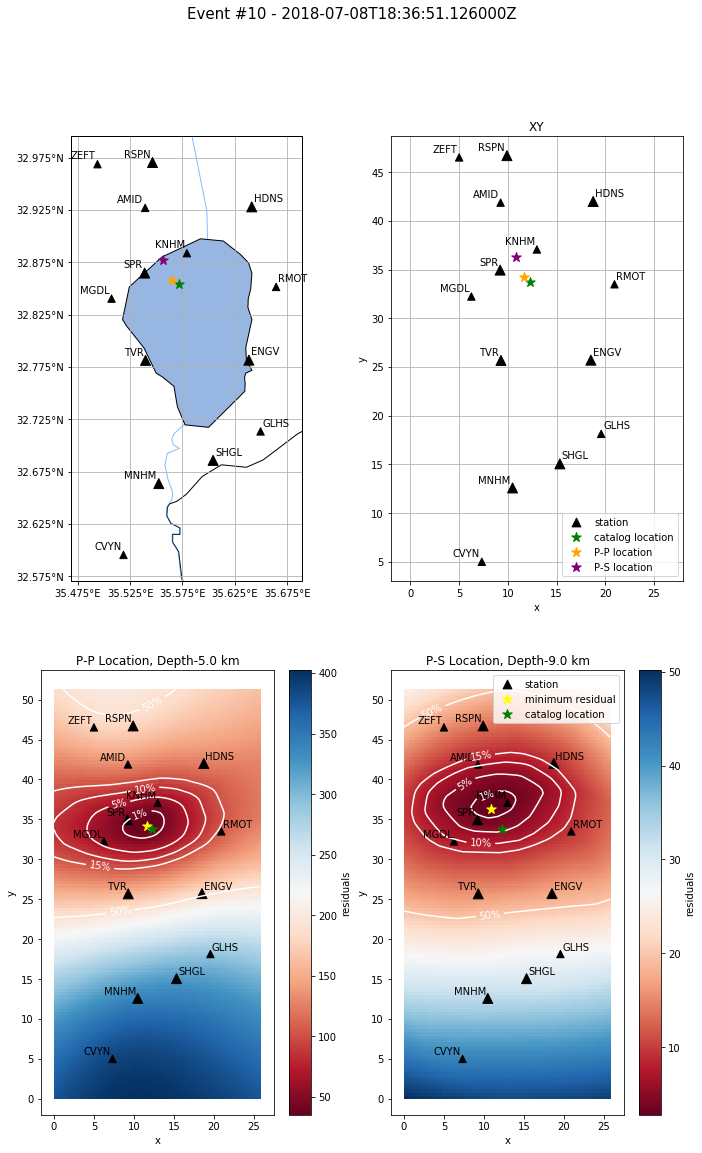

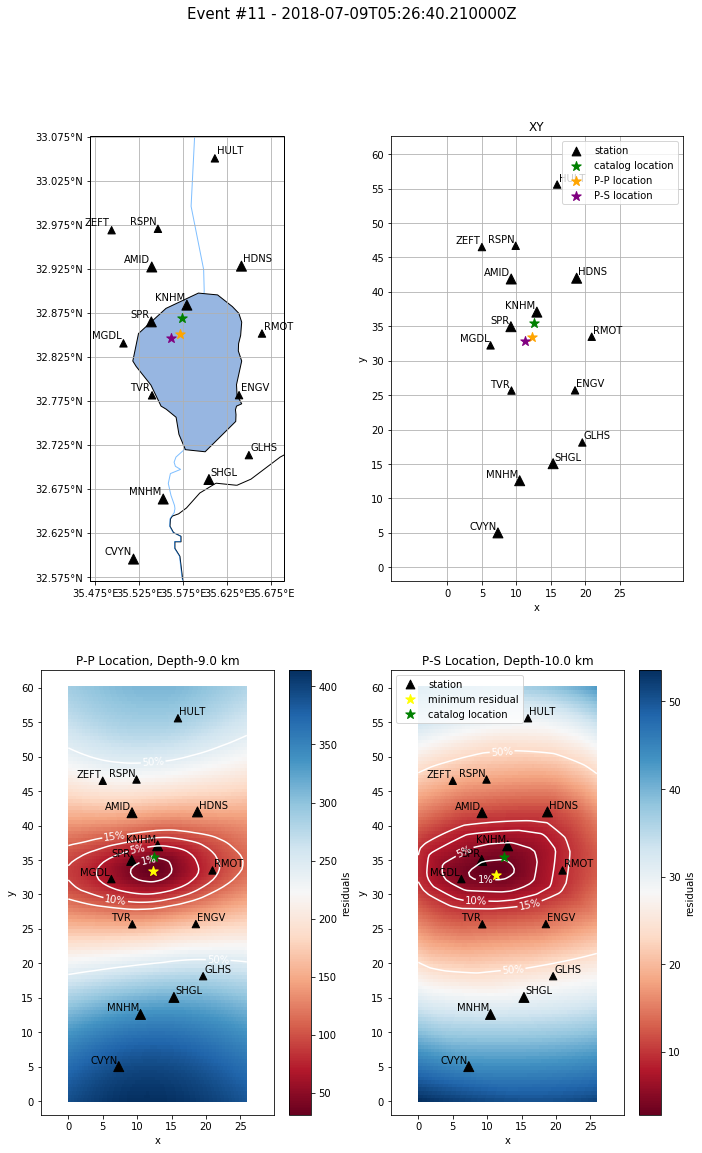

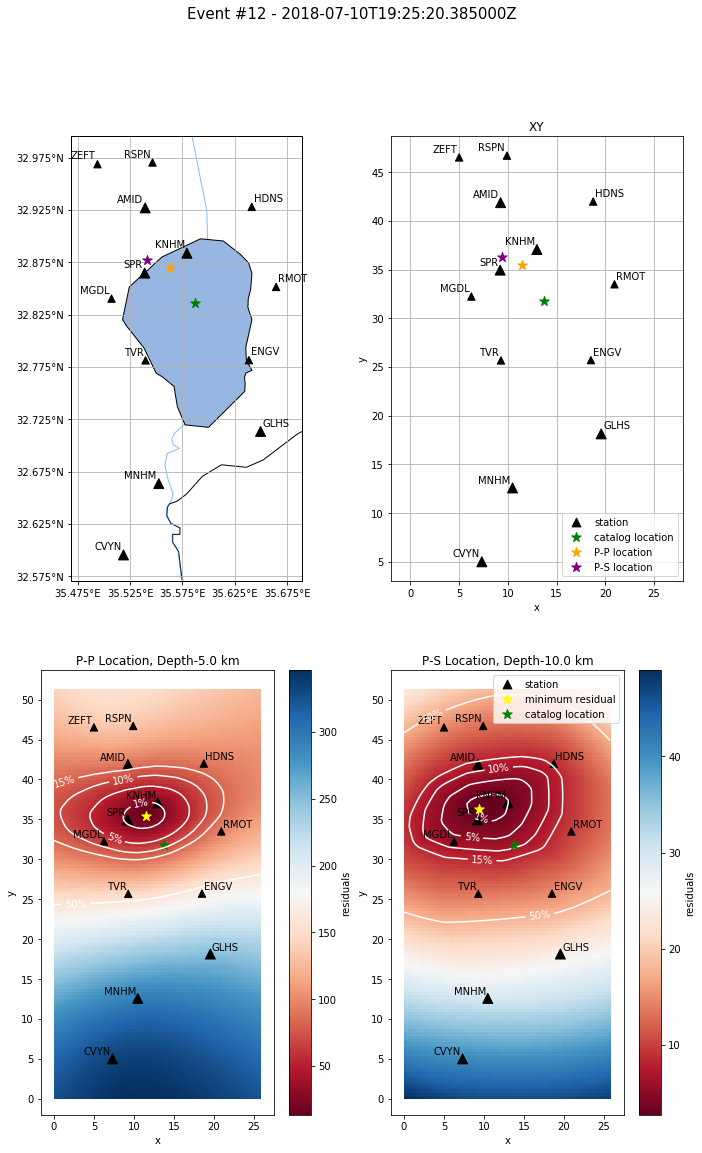

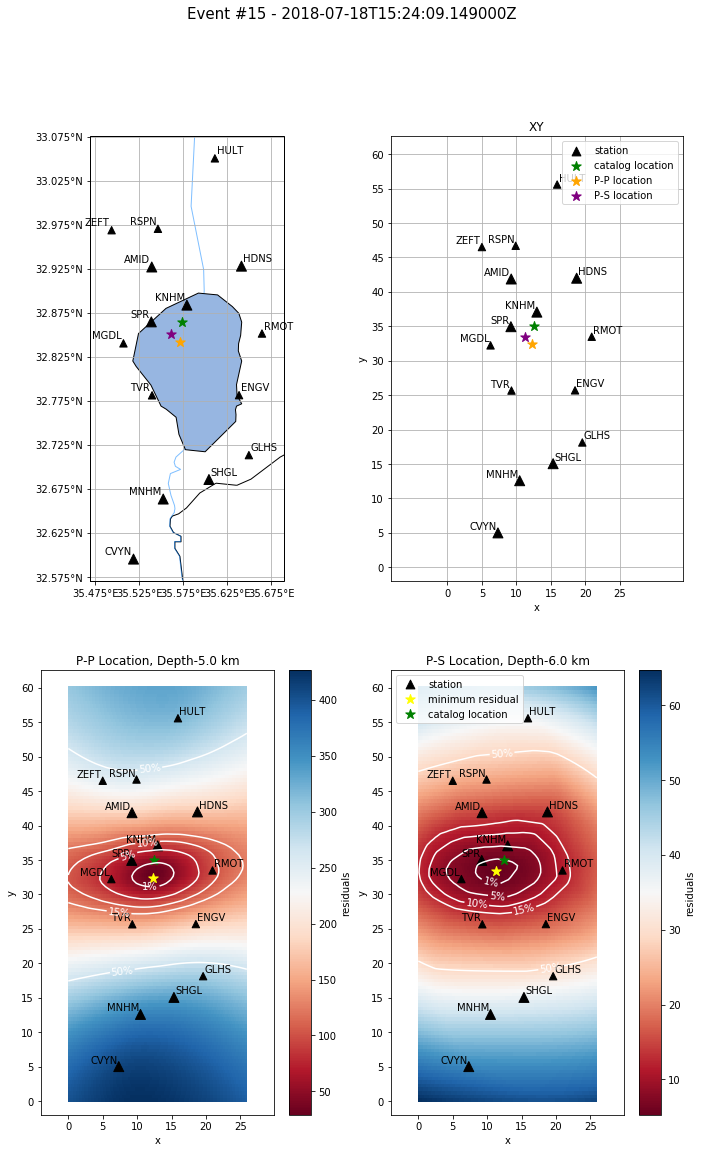

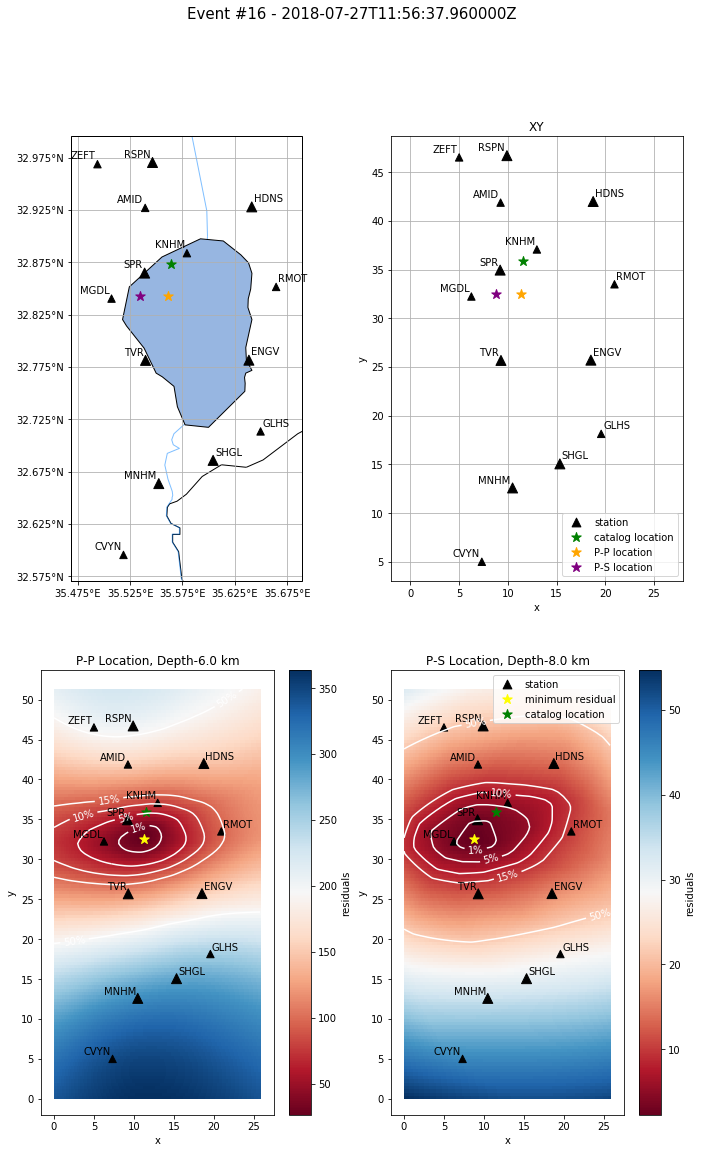

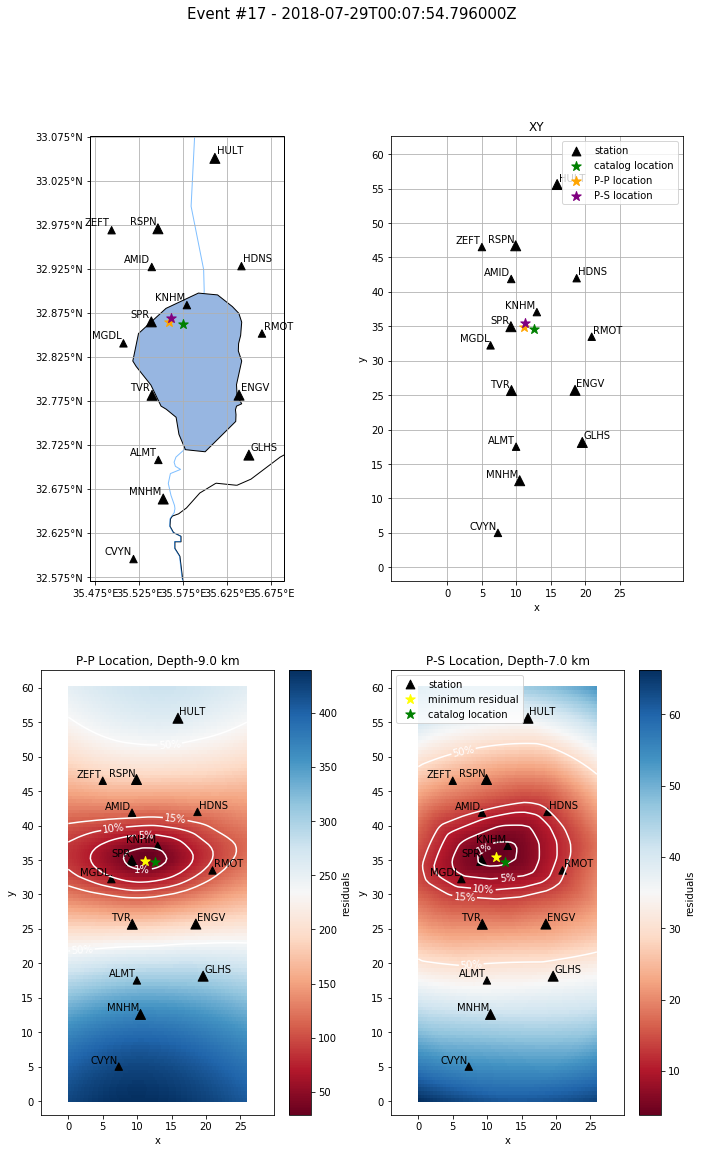

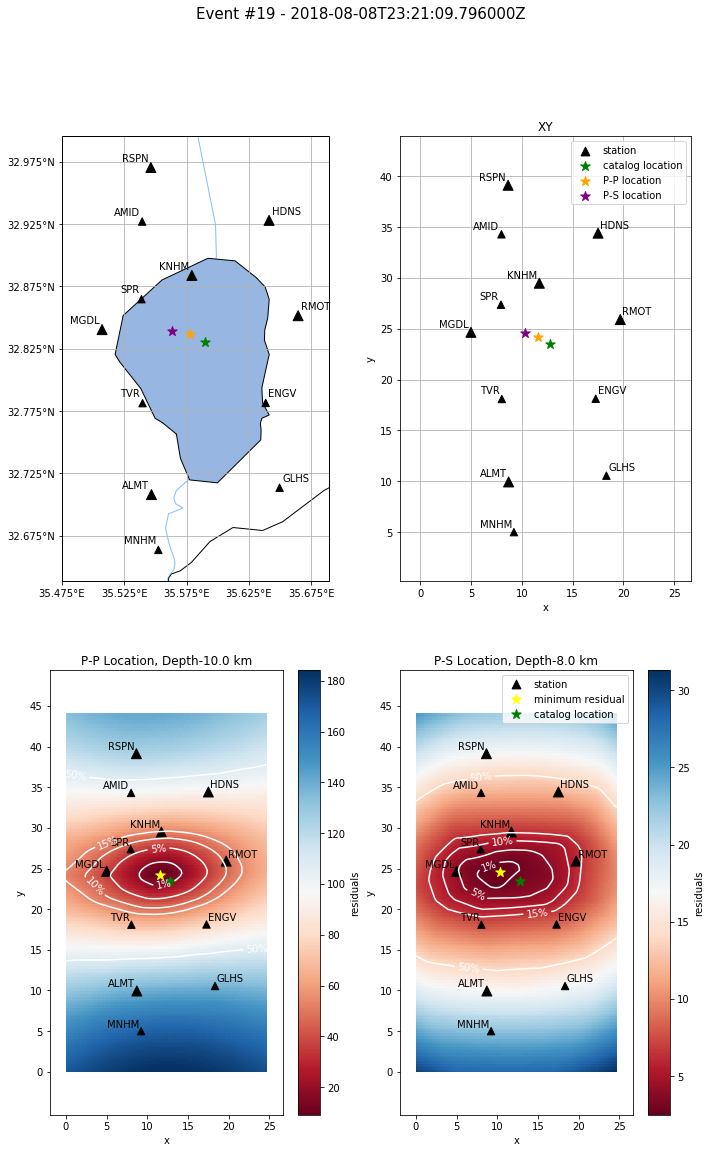

In [349]:
label_offset_x, label_offset_y = 0.002, 0.005

for i, event_data in enumerate(events_dfs):
    event_data = event_data.dropna(axis="index", subset=["tp", "ts"])
    wx = int((event_data["x"].max() + 5) /my_events.loc[i, "delta_x"])
    wy = int((event_data["y"].max() + 5) / my_events.loc[i, "delta_y"])

    fig = plt.figure(figsize = (11.5, 18))
    # fig, axes = plt.subplots(2, 2, figsize = (15, 20))
    fig.suptitle(f"Event #{i} - {my_events.loc[i, 'event time']}", fontsize=15)

    ax = fig.add_subplot(2, 2 ,1, projection = projection)
    ax1 = fig.add_subplot(2, 2 ,2)
    ax2 = fig.add_subplot(2, 2 ,3)
    ax3 = fig.add_subplot(2, 2 ,4)

    ax = plot_map(ax, event_data.lat.min(), event_data.lat.max(), event_data.lon.min(), event_data.lon.max())    
    ax = plot_stations(ax, event_data, "lon", "lat", label_offset_x, label_offset_y, 35.6)

    ax.scatter(my_events.iloc[i]["cat_lon"], my_events.iloc[i]["cat_lat"], marker="*", s=100, color='green',
               zorder=2, label="catalog location")
    ax.scatter(my_events.iloc[i]["pp_lon"], my_events.iloc[i]["pp_lat"], marker="*", s=100, color='orange',
               zorder=2, label="P-P location")
    ax.scatter(my_events.iloc[i]["ps_lon"], my_events.iloc[i]["ps_lat"], marker="*", s=100, color='purple',
               zorder=2, label="P-S location")

    ax1 = plot_stations_xy(ax1, event_data, title="XY", x_lim_add=5, y_lim_add=5)
    ax1.scatter(my_events.loc[i, "cat_x"], my_events.loc[i, "cat_y"],
                zorder=2, marker="*", s=100, color='green', label="catalog location")
    ax1.scatter(my_events.loc[i, "pp_x"], my_events.loc[i, "pp_y"], marker="*", s=100, color='orange',
                zorder=2, label="P-P location")
    ax1.scatter(my_events.loc[i, "ps_x"], my_events.loc[i, "ps_y"], marker="*", s=100, color='purple',
                zorder=2, label="P-S location")
    ax1.legend()
    
    ax2.scatter(my_events.loc[i, "cat_x"], my_events.loc[i, "cat_y"],
                zorder=2, marker="*", s=100, color='g', label="catalog location")
    ax2 = plot_location(ax2, fig, event_data, res_events[i]["pp"]["mrs"], wx, wy, 
                        my_events.loc[i, "delta_x"], my_events.loc[i, "delta_y"],
                        title=f"P-P Location, Depth-{my_events.iloc[i]['pp_depth']} km")
    
    ax3 = plot_location(ax3, fig, event_data, res_events[i]["ps"]["mrs"], wx, wy,
                        my_events.loc[i, "delta_x"], my_events.loc[i, "delta_y"], 
                        title=f"P-S Location, Depth-{my_events.iloc[i]['ps_depth']} km")
    ax3.scatter(my_events.loc[i, "cat_x"], my_events.loc[i, "cat_y"],
                zorder=2, marker="*", s=100, color='g', label="catalog location")
    ax3.legend()
    fig.savefig(f"figures/location-{my_events.loc[i, 'event time']}.jpg")

### P-P location

In [ ]:
# mean residual sum (storage for residuals)
def pp_location(event_data, wx, wy, delta_x, delta_y, vps=(4.0, ), depths=(5, 6, 7, 8, 9)):
    mrss = []
    mrs_min = np.full((wy, wx), np. inf)
    min_depth = depths[0]
    for vp, depth in itertools.product(vps, depths):
        mrs = np.zeros((wy, wx))

        # xv, yv = np.meshgrid(np.arange(wx) * delta, np.arange(wy) * delta)
        # tt2 = np.sqrt((xv - np.tile(event_data["x"].values, (100, 100, 1)).T)**2 +
        #               (yv - np.tile(event_data["y"].values, (100, 100, 1)).T)**2 +
        #               (0 - depth)**2) / vp

        for y in range(wy):
            for x in range(wx):

                gx = x * delta_x
                gy = y * delta_y
                tt = [0 for i in range(num_stations)]
                r_sum = 0

                for s in range(num_stations):      
                    tt[s]= np.sqrt((event_data.iloc[s]["x"] - gx)**2
                                   + (event_data.iloc[s]["y"] - gy)**2 
                                   + ((event_data.iloc[s]["elevation"] - event_data.iloc[s]["local_depth"]) / 1000 - depth)**2) / vp

                for ci in range(len(pairs)): 
                    #CONSTRAINTS (ci): thickness of constraints
                    #if np.abs((tt[i[ci][0]] - tt[i[ci][1]]) - c[ci]) < 0.1: rSum+=1
                    #RESIDUA
                    r_sum += np.abs((tt[pairs[ci][0]] - tt[pairs[ci][1]]) - time_differences[ci])

        #         tt1 = [np.sqrt((event_data.iloc[s]["x"] - gx)**2 + (event_data.iloc[s]["y"] - gy)**2 + (0 - depth)**2) / vp for s in range(num_stations)]
        #         rSum1 = np.abs([(tt[ci[0]] - tt[ci[1]]) - td for ci, td in zip(pairs, time_differences)]).sum()
        #         print(rSum, rSum1)
                mrs[y][x] = r_sum
        mrss.append(mrs)
        if mrs.min() < mrs_min.min():
            mrs_min = mrs.copy()
            min_depth = depth
    location = np.unravel_index(mrs.argmin(), mrs.shape)
    
    return (*location, min_depth), mrs.min(), vp, mrs_min, mrss

In [ ]:
results_pp = pp_location(event_data, wx, wy, delta_x, delta_y)

### **ML Magnitude**

/home/nivkeren/anaconda3/envs/work_env/lib/python3.7/site-packages/obspy/core/inventory/response.py:1876: UserWarning: More than one PolesZerosResponseStage encountered. Returning first one found.
  warnings.warn(msg)


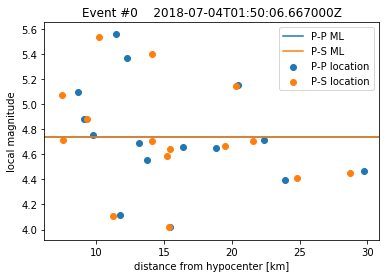

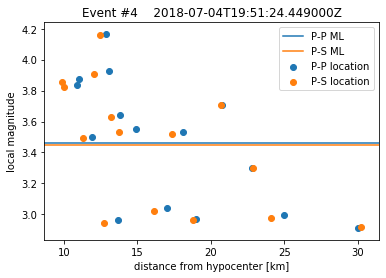

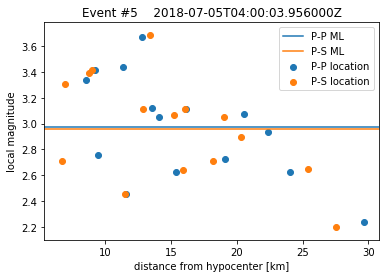

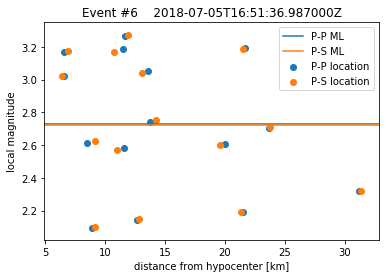

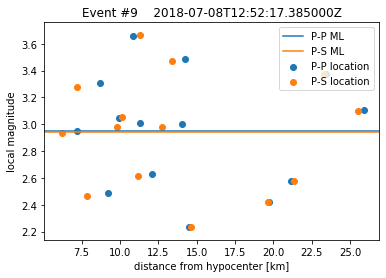

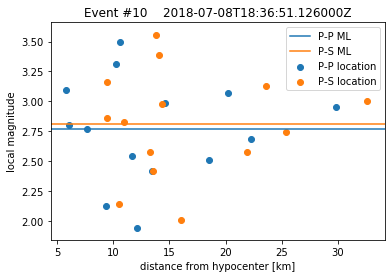

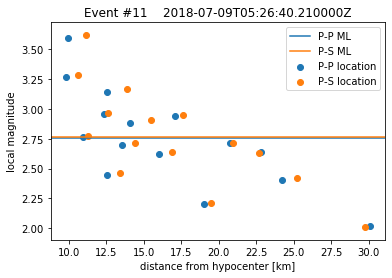

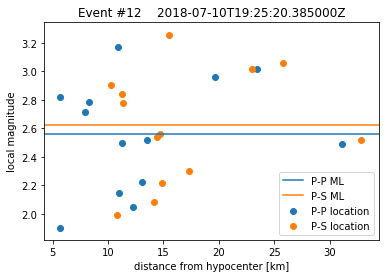

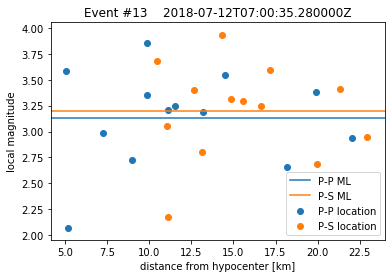

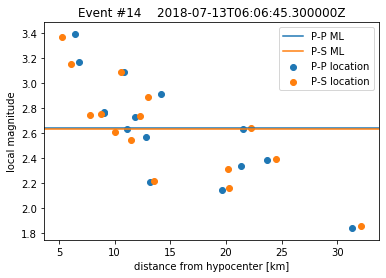

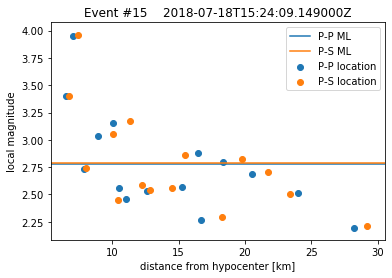

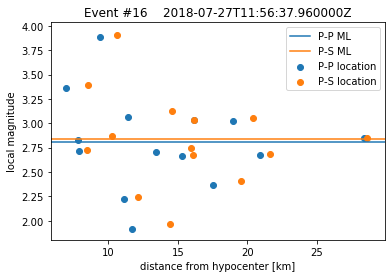

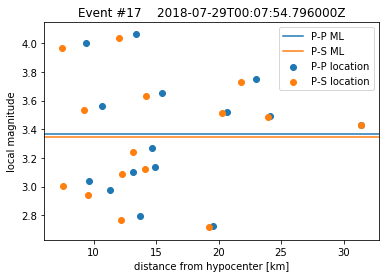

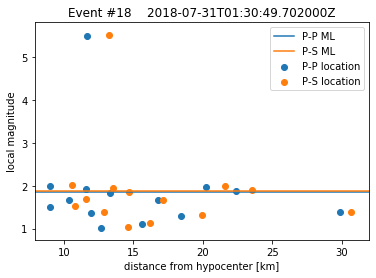

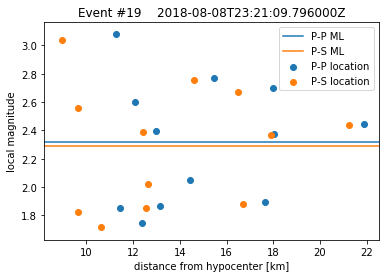

In [375]:
for i, event_data in enumerate(events_dfs):
    st = waveforms_raw[i]
    event_data = events_dfs[i].dropna(axis="index", subset=["tp", "ts"])

    stz = st.select(channel="EN*", component = "N")
    # amplitudes_df = pd.DataFrame(columns=["event_time", "station", "max_amplitude", "pp_distance", "ps_distance", "ml"])

    for trz, (idx, sta) in zip(stz, event_data.iterrows()):
        network = trz.stats.network
        station = trz.stats.station
        location = trz.stats.location
        channel = trz.stats.channel
        response = inv.get_response(f"{network}.{station}.{location}.{channel}",
                                    trz.stats.starttime)

        paz = {"gain": response.response_stages[0].stage_gain,
               "poles": response.get_paz().poles,
               "sensitivity": response.instrument_sensitivity.value,
               "zeros": response.get_paz().zeros}
        st_station = st.select(station=station, channel=f"{channel[0: 2]}?").sort(reverse=True).copy() # order: Z, N, E
        st_station_wa = st_station.copy().simulate(paz_remove=paz, paz_simulate=PAZ_WA,
                                                   remove_sensitivity=True, simulate_sensitivity=True, water_level=0)

        for tr in st_station:
            tr.data = tr.data.astype(np.float) / paz["sensitivity"] #* PAZ_WA["sensitivity"]
        st_station_filtered = st_station.detrend("linear").filter("bandpass", freqmin=1, freqmax=10, corners = 4, zerophase = True)

        st_station_wa_filtered = st_station_wa.detrend("linear").filter("bandpass", freqmin=1, freqmax=10, corners = 4, zerophase = True)
        st_velocity_wa = st_station_wa_filtered.copy().integrate()

        st_velocity = st_station_filtered.copy().integrate("cumtrapz")
        amplitude = np.abs(st_velocity.max())[1:].max()
        event_data.loc[idx, "max_amplitude"] = amplitude

    event_data["pp_magnitude"] = magnitude_local(event_data["max_amplitude"], event_data["pp_distance"])
    event_data["ps_magnitude"] = magnitude_local(event_data["max_amplitude"], event_data["ps_distance"])

    my_events.loc[i, "pp_mag"] = event_data['pp_magnitude'].mean()
    my_events.loc[i, "ps_mag"] = event_data['ps_magnitude'].mean()

    fig, ax = plt.subplots(1, 1)
    ax = plot_ml_distance(ax, event_data)

    ax.set_title(f"Event #{i}    {my_events.loc[i, 'event time']}")
    plt.savefig(f"figures/ml-{my_events.loc[i, 'event time']}.jpg", dpi=300, quality=95)

----

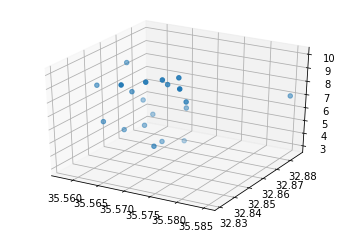

In [359]:
fig = plt.figure()
ax_3d = fig.add_subplot(projection="3d")
ax_3d.scatter(my_events["pp_lon"], my_events["pp_lat"], my_events["pp_depth"])

In [369]:
my_events[["cat_mag", "pp_mag", "ps_mag"]]

cat_mag    pp_mag    ps_mag
0    4.797476941 M   4.040003  4.037409
1    2.552366975 M   1.960840  2.003593
2    3.288243713 M   2.658921  2.732567
3    4.761445325 M   4.406606  4.412831
4    3.821342778 M   2.761574  2.750621
5    2.975286543 M   2.274296  2.261080
6    2.957468776 M   2.027229  2.026585
7    2.760879312 M   1.843461  1.846369
8    3.993414954 M   3.201265  3.192474
9    3.099346613 M   2.250291  2.240077
10   2.912091227 M   2.067128  2.114239
11   2.544967346 M   2.053482  2.065278
12   2.661807031 M   1.863481  1.922158
13   3.304634746 M   2.433474  2.495331
14   2.620838931 M   1.938642  1.932855
15   2.860077441 M   2.082311  2.091101
16   2.751016607 M   2.109572  2.135800
17   3.482041205 M   2.668186  2.648171
18    3.26786428 M   1.161477  1.184970
19   2.529741661 M   1.616103  1.593205

In [364]:
my_events[["cat_mag", "pp_mag", "ps_mag"]]

cat_mag    pp_mag    ps_mag
0    4.797476941 M   3.040003  3.037409
1    2.552366975 M   0.960840  1.003593
2    3.288243713 M   1.658921  1.732567
3    4.761445325 M   3.406606  3.412831
4    3.821342778 M   1.761574  1.750621
5    2.975286543 M   1.274296  1.261080
6    2.957468776 M   1.027229  1.026585
7    2.760879312 M   0.843461  0.846369
8    3.993414954 M   2.201265  2.192474
9    3.099346613 M   1.250291  1.240077
10   2.912091227 M   1.067128  1.114239
11   2.544967346 M   1.053482  1.065278
12   2.661807031 M   0.863481  0.922158
13   3.304634746 M   1.433474  1.495331
14   2.620838931 M   0.938642  0.932855
15   2.860077441 M   1.082311  1.091101
16   2.751016607 M   1.109572  1.135800
17   3.482041205 M   1.668186  1.648171
18    3.26786428 M   0.161477  0.184970
19   2.529741661 M   0.616103  0.593205

In [371]:
my_events[["cat_mag", "pp_mag", "ps_mag"]]

cat_mag    pp_mag    ps_mag
0    4.797476941 M   4.341033  4.338439
1    2.552366975 M   2.261870  2.304623
2    3.288243713 M   2.959951  3.033597
3    4.761445325 M   4.707636  4.713861
4    3.821342778 M   3.062604  3.051651
5    2.975286543 M   2.575326  2.562110
6    2.957468776 M   2.328259  2.327615
7    2.760879312 M   2.144491  2.147399
8    3.993414954 M   3.502295  3.493504
9    3.099346613 M   2.551321  2.541107
10   2.912091227 M   2.368158  2.415269
11   2.544967346 M   2.354512  2.366308
12   2.661807031 M   2.164511  2.223188
13   3.304634746 M   2.734504  2.796361
14   2.620838931 M   2.239672  2.233885
15   2.860077441 M   2.383341  2.392131
16   2.751016607 M   2.410602  2.436830
17   3.482041205 M   2.969216  2.949201
18    3.26786428 M   1.462507  1.486000
19   2.529741661 M   1.917133  1.894235

In [373]:
my_events[["cat_mag", "pp_mag", "ps_mag"]]

cat_mag    pp_mag    ps_mag
0    4.797476941 M   4.517124  4.514530
1    2.552366975 M   2.437962  2.480714
2    3.288243713 M   3.136042  3.209688
3    4.761445325 M   4.883727  4.889952
4    3.821342778 M   3.238696  3.227743
5    2.975286543 M   2.751417  2.738201
6    2.957468776 M   2.504350  2.503707
7    2.760879312 M   2.320582  2.323491
8    3.993414954 M   3.678386  3.669595
9    3.099346613 M   2.727412  2.717198
10   2.912091227 M   2.544249  2.591360
11   2.544967346 M   2.530604  2.542399
12   2.661807031 M   2.340603  2.399279
13   3.304634746 M   2.910595  2.972453
14   2.620838931 M   2.415763  2.409976
15   2.860077441 M   2.559432  2.568222
16   2.751016607 M   2.586694  2.612921
17   3.482041205 M   3.145307  3.125292
18    3.26786428 M   1.638598  1.662091
19   2.529741661 M   2.093224  2.070326